In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

froot = './data/k562_epft_chr22_norm'

df = pd.read_csv(froot + ".csv")

In [2]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score        gc  \
0        22  17736387  17736396      -  ENSG00000015475    0.0  0.699989   
1        22  17736397  17736406      -  ENSG00000015475    0.0  0.699989   
2        22  17736407  17736416      -  ENSG00000015475    0.0  0.699989   
3        22  17736417  17736426      -  ENSG00000015475    0.0  0.158013   
4        22  17736427  17736436      -  ENSG00000015475    0.0  1.241965   

       rpts      ctcf   histone  sj5  sj3  dms  lambda_alphaj      zeta  
0 -0.491843 -0.061105 -0.295750  0.0  0.0  0.0       0.211445  1.204263  
1 -0.491843 -0.061805 -0.309448  0.0  0.0  0.0       0.211445  1.203544  
2 -0.491843 -0.061114 -0.297420  0.0  0.0  0.0       0.211445  1.204176  
3 -0.491843 -0.061809 -0.309120  0.0  0.0  0.0       0.211445  1.056701  
4 -0.491843 -0.061809 -0.309495  0.0  0.0  0.0       0.211445  1.370809  


In [3]:
column_names = np.array(df.columns)
feature_names = column_names[6:-2]#[6:-7]
num_features = len(feature_names)
#nucleotides = column_names[-6:-2]
print(feature_names)
#print(nucleotides)
num_samples = df.shape[0]

# process read counts
X_ji = df['score'].values

# process GLM simulated elongation rates
Z_ji = df['zeta'].values

['gc' 'rpts' 'ctcf' 'histone' 'sj5' 'sj3' 'dms']


In [4]:
print("Number of Samples: " + str(num_samples))

Number of Samples: 449874


In [5]:
print("Number of Features: " + str(num_features))

Number of Features: 7


In [6]:
#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   sample_1: [feat_1, feat_2,...,feat_n],
    #   sample_2: [feat_1, feat_2,...,feat_n],
    # ]

Y_ji = df.iloc[:, 6:-2].values#df.iloc[:, 6:-7].values

In [7]:
C_j = df['lambda_alphaj'].values

In [8]:
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)

CUDA (GPU support) is available: True
Number of GPUs available: 1


In [9]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.Y_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(self.Y_ji[idx], dtype=torch.float32),
            'X_ji': torch.tensor(self.X_ji[idx], dtype=torch.float32),
            'C_j': torch.tensor(self.C_j[idx], dtype=torch.float32),
            'Z_ji': torch.tensor(self.Z_ji[idx], dtype=torch.float32)
        }

In [10]:
dataset = CustomDataset(Y_ji, X_ji, C_j, Z_ji)

train_percent = 0.8
val_percent = 0.1
test_percent = 0.1
train_size = int(train_percent * num_samples)
val_size = int(val_percent * num_samples)
test_size = num_samples - train_size - val_size
trnset, valset, tstset = td.random_split(dataset, [train_size, val_size, test_size])

batch_size = 64

In [11]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(num_features, 1)

#class CNN(nn.Module):
#    def __init__(self):
#        super(CNN, self).__init__()
#        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=7, stride=1, padding=1)
#        self.pool = nn.MaxPool1d(2, 2)
#        self.fc = nn.Linear(64, 1)  

#    def forward(self, x):
#        x = x.unsqueeze(1)
#        x = self.pool(F.relu(self.conv1(x)))
#        x = torch.flatten(x, 1)
#        x = self.fc(x)
#        return x
    
#model = CNN()

if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

print(model)

arr = torch.randn((batch_size,num_features)).to(device)
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)

Linear(in_features=7, out_features=1, bias=True)
torch.Size([64, 1])
Number of parameters: 8
Model is on device: cuda:0


In [12]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        #print(Z_ji.shape)
        epsilon = 1e-8
        clipped_Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(clipped_Z_ji) + C_j * torch.exp(-clipped_Z_ji)
        return (loss).mean()

In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 30

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    trndl = DataLoader(trnset, batch_size=batch_size, num_workers=7, shuffle=True, pin_memory=True)
    for i, batch in enumerate(trndl):
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji'].to(device)
        X_ji_batch = batch['X_ji'].to(device)
        C_j_batch = batch['C_j'].to(device)
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
    loss_hist_train[epoch] /= len(trndl)
    del trndl
    
    model.eval()
    valdl = DataLoader(valset, batch_size=batch_size, num_workers=7, shuffle=False, pin_memory=True)
    with torch.no_grad():
        for batch in valdl:
            Y_ji_batch = batch['Y_ji'].to(device)
            X_ji_batch = batch['X_ji'].to(device)
            C_j_batch = batch['C_j'].to(device)
            outputs = model(Y_ji_batch)
            loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            loss_hist_valid[epoch] += loss.item()
        loss_hist_valid[epoch] /= len(valdl)
    del valdl
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.4f} val_loss: '
          f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: -2.1993 val_loss: -2.4343
Epoch 2
Epoch 2 trn_loss: -3.1295 val_loss: -3.3687
Epoch 3
Epoch 3 trn_loss: -3.4611 val_loss: -3.4952
Epoch 4
Epoch 4 trn_loss: -3.5863 val_loss: -3.6633
Epoch 5
Epoch 5 trn_loss: -4.4457 val_loss: -4.4866
Epoch 6
Epoch 6 trn_loss: -4.5826 val_loss: -4.5816
Epoch 7
Epoch 7 trn_loss: -4.6649 val_loss: -4.6965
Epoch 8
Epoch 8 trn_loss: -5.1869 val_loss: -5.7485
Epoch 9
Epoch 9 trn_loss: -6.3636 val_loss: -6.7012
Epoch 10
Epoch 10 trn_loss: -7.0939 val_loss: -7.1771
Epoch 11
Epoch 11 trn_loss: -7.3408 val_loss: -7.4981
Epoch 12
Epoch 12 trn_loss: -7.5316 val_loss: -7.5043
Epoch 13
Epoch 13 trn_loss: -7.5427 val_loss: -7.5185
Epoch 14
Epoch 14 trn_loss: -7.5527 val_loss: -7.5212
Epoch 15
Epoch 15 trn_loss: -7.5565 val_loss: -7.5234
Epoch 16
Epoch 16 trn_loss: -7.5593 val_loss: -7.5282
Epoch 17
Epoch 17 trn_loss: -7.5626 val_loss: -7.5295
Epoch 18
Epoch 18 trn_loss: -7.5676 val_loss: -7.5360
Epoch 19
Epoch 19 trn_loss: -7.5780 val_loss: 

In [14]:
weights = model.weight.data.cpu().numpy()
bias = model.bias.data.cpu().numpy()

combined = ', '.join([f'"{s}": {f}' for s, f in zip(feature_names, weights[0])])
print(combined)

"gc": -0.15786431729793549, "rpts": 0.07097271084785461, "ctcf": 0.01823011226952076, "histone": -0.24834850430488586, "sj5": 0.019329356029629707, "sj3": 0.062002938240766525, "dms": -0.012585354968905449


In [112]:
# GLM K

# ctcf: -0.008355491
# sj5: -0.114737868
# sj3: -0.181587543
# dms: -0.080544917
# rpts: 0.063179057

# gc: -0.240107566
# histone: -0.043173335

In [15]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"models/Elongation_Model_{timestamp}.pth"
torch.save(model.state_dict(), filename)

In [24]:
"""
model = Model(num_features)
model.load_state_dict(torch.load("models/Elongation_Model.pth"))
cuda_available = torch.cuda.is_available()
print("CUDA (GPU support) is available:", cuda_available)
num_gpus = torch.cuda.device_count()
print("Number of GPUs available:", num_gpus)
if cuda_available:
    if num_gpus > 1:
        print("Using", num_gpus, "GPUs")
        model = torch.nn.DataParallel(model)
    model = model.to('cuda')

first_param_device = next(model.parameters()).device
print("Model is on device:", first_param_device)
"""

'\nmodel = Model(num_features)\nmodel.load_state_dict(torch.load("models/Elongation_Model.pth"))\ncuda_available = torch.cuda.is_available()\nprint("CUDA (GPU support) is available:", cuda_available)\nnum_gpus = torch.cuda.device_count()\nprint("Number of GPUs available:", num_gpus)\nif cuda_available:\n    if num_gpus > 1:\n        print("Using", num_gpus, "GPUs")\n        model = torch.nn.DataParallel(model)\n    model = model.to(\'cuda\')\n\nfirst_param_device = next(model.parameters()).device\nprint("Model is on device:", first_param_device)\n'

<function matplotlib.pyplot.show(close=None, block=None)>

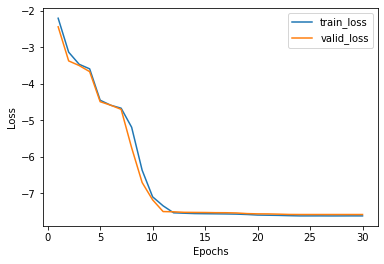

In [16]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

In [17]:
def plot_data(simulated_zeta, predicted_zeta):
    indices = range(len(simulated_zeta))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(indices, predicted_zeta, color='blue', alpha=0.4)
    ax.plot(indices, simulated_zeta, color='orange', alpha=0.4)
    
    ax.scatter(indices, predicted_zeta, color='blue', label='Predicted Zeta')
    ax.scatter(indices, simulated_zeta, color='orange', label='Simulated Zeta')
    
    ax.set_title('Predicted vs Simulated Elongation Rate')
    ax.set_xlabel('Index')
    ax.set_ylabel('Elongation Rate')
    ax.legend()

    plt.show()


In [18]:
tstdl = DataLoader(tstset, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

number of samples: 4
predicted zeta:
tensor([0.6544, 0.2519, 0.7157, 0.4520, 0.6043, 0.4339, 0.4568, 0.4270, 0.7702,
        0.5319, 0.4591, 0.4096, 0.4493, 0.6571, 0.3991, 0.4641, 0.6653, 0.5603,
        0.4644, 0.6165, 0.5938, 0.5369, 0.3703, 0.2141, 0.7784, 0.6637, 0.4517,
        0.5577, 0.4928, 0.4678, 0.5023, 0.4995, 0.6000, 0.5112, 0.5191, 0.3430,
        0.6078, 0.5522, 0.6085, 0.5520, 0.4778, 0.6225, 0.4632, 0.1809, 0.6328,
        0.4884, 0.5575, 0.3869, 0.4539, 0.5152, 0.3923, 0.6072, 0.5516, 0.5084,
        0.3584, 0.5530, 0.6625, 0.5960, 0.0556, 0.5148, 0.6066, 0.6092, 0.5478,
        0.3902])
simulated zeta:
tensor([0.7179, 1.5081, 0.6976, 1.0818, 0.8168, 1.2228, 1.2118, 1.3758, 0.5939,
        0.6085, 1.2107, 1.4032, 1.2152, 0.7174, 1.5621, 1.2084, 0.7928, 0.8277,
        1.2083, 0.9015, 0.8554, 0.9356, 1.1752, 1.5875, 0.6126, 0.7161, 1.2141,
        0.9295, 1.1803, 1.2067, 1.0622, 1.0952, 0.9058, 1.0589, 1.1697, 1.4292,
        0.8160, 0.9311, 0.8158, 0.9311, 0.9548, 0.

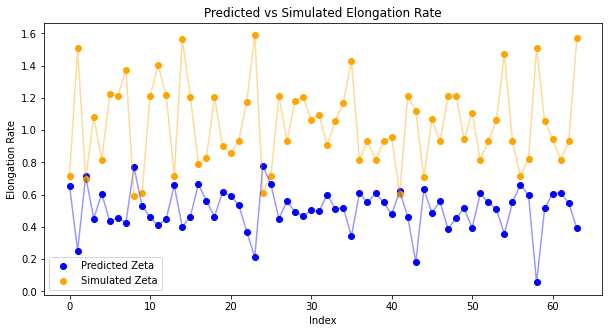

number of samples: 4
predicted zeta:
tensor([0.5962, 0.5441, 0.3176, 0.5886, 0.4372, 0.5605, 0.4272, 0.5437, 0.4863,
        0.5134, 0.5146, 0.5094, 0.5428, 0.3490, 0.5119, 0.7781, 0.5988, 0.6428,
        0.4882, 0.4248, 0.4860, 0.3715, 0.4336, 0.4694, 0.5541, 0.4583, 0.5559,
        0.4036, 0.5941, 0.4843, 0.5508, 0.4709, 0.4392, 0.4374, 0.4890, 0.4890,
        0.5077, 0.4049, 0.4675, 0.5107, 0.3864, 0.8515, 0.4947, 0.5801, 0.3502,
        0.2574, 0.4638, 0.4233, 0.6005, 0.7125, 0.6546, 0.6390, 0.5112, 0.4867,
        0.3017, 0.6886, 0.4760, 0.5696, 0.5460, 0.5168, 0.4991, 0.5592, 0.3894,
        0.4995])
simulated zeta:
tensor([0.9068, 0.9335, 1.4489, 0.8205, 1.2211, 0.9286, 1.2260, 0.9336, 1.0682,
        0.6584, 1.0577, 1.1735, 0.9338, 0.8986, 1.0587, 0.6127, 0.8181, 0.7201,
        1.0674, 1.3887, 0.8914, 1.5822, 1.0340, 1.2060, 0.9305, 1.2111, 0.9300,
        1.1213, 0.8192, 1.0689, 0.9315, 1.2053, 1.2201, 1.2209, 0.9731, 1.6678,
        1.0413, 1.2339, 1.1543, 1.0591, 1.5912, 0.

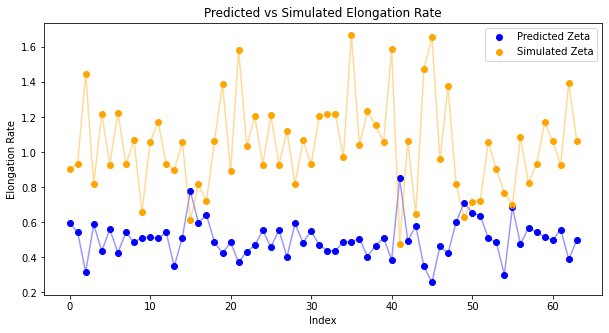

number of samples: 4
predicted zeta:
tensor([0.3585, 0.4711, 0.4076, 0.4971, 0.6046, 0.6170, 0.0902, 0.5196, 0.3586,
        0.6956, 0.5273, 0.4324, 0.5465, 0.4330, 0.5314, 0.5202, 0.6571, 0.6011,
        0.4942, 0.4755, 0.6512, 0.7232, 0.4776, 0.4683, 0.6668, 0.3787, 0.3402,
        0.3871, 0.3839, 0.5064, 0.6029, 0.6046, 0.7276, 0.4409, 0.4643, 0.8459,
        0.6043, 0.5962, 0.4645, 0.7174, 0.4193, 0.3947, 0.4345, 0.0090, 0.5583,
        0.7174, 0.5102, 0.5598, 0.5084, 0.6125, 0.3772, 0.4681, 0.4334, 0.6076,
        0.6312, 0.4498, 0.6095, 0.4806, 0.3672, 0.4830, 0.4719, 0.5376, 0.5942,
        0.7014])
simulated zeta:
tensor([1.7860, 1.2053, 0.9501, 1.0641, 0.9046, 0.9014, 1.4072, 1.1695, 1.7789,
        0.6330, 0.9386, 1.3728, 0.9327, 1.3725, 0.9373, 1.1692, 0.7174, 0.9055,
        1.0651, 1.3327, 0.7185, 0.6287, 0.9549, 1.2065, 0.7925, 1.4051, 1.2649,
        1.5705, 1.4058, 0.9330, 0.9051, 0.8167, 0.6956, 1.2492, 1.2638, 0.5381,
        0.9046, 0.8187, 0.9595, 0.6296, 1.3802, 1.

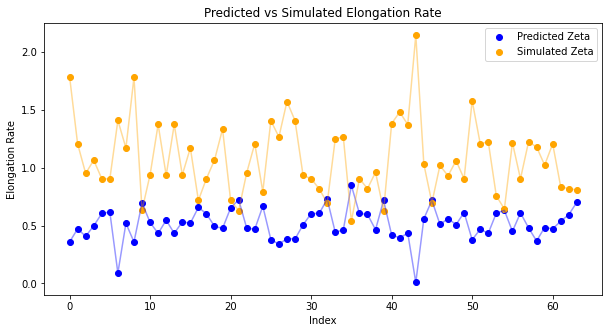

number of samples: 4
predicted zeta:
tensor([0.9402, 0.5536, 0.6151, 0.4410, 0.7813, 0.5102, 0.3062, 0.7304, 0.5733,
        0.1493, 0.5143, 0.5006, 0.5130, 0.4638, 0.5420, 0.4274, 0.6021, 0.5405,
        0.4594, 0.5863, 0.3998, 0.4138, 0.5156, 0.4651, 0.2923, 0.7931, 0.4128,
        0.6184, 0.8529, 0.3779, 0.5569, 0.4626, 0.2880, 0.5590, 0.6022, 0.7198,
        0.7131, 0.7204, 0.4260, 0.4662, 0.7180, 0.5201, 0.5094, 0.6061, 0.8658,
        0.6639, 0.4636, 0.9481, 0.5041, 0.5511, 0.4216, 0.4112, 0.4706, 0.5493,
        0.0010, 0.6528, 0.4985, 0.5100, 0.5583, 0.6106, 0.7853, 0.5929, 0.6497,
        0.5146])
simulated zeta:
tensor([0.4708, 0.9323, 0.7144, 1.2193, 0.6122, 1.0593, 1.6363, 0.5610, 0.8243,
        1.1688, 1.0578, 1.0628, 1.1721, 1.2086, 0.9108, 1.3756, 0.8173, 0.9345,
        1.2105, 0.9095, 1.5617, 1.3834, 0.5942, 1.2082, 1.4695, 0.6107, 1.2333,
        0.5864, 0.5373, 1.4166, 0.9299, 1.0775, 1.2401, 1.0290, 0.8173, 0.6292,
        0.6302, 0.6074, 1.4222, 1.0760, 0.6295, 1.

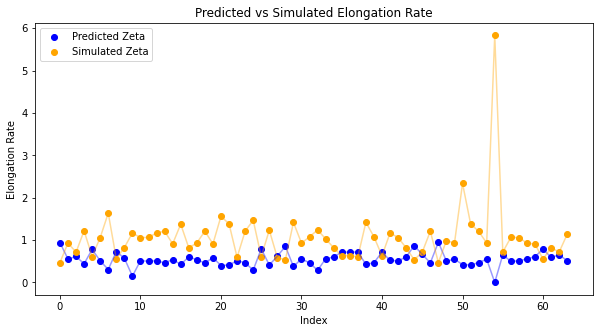

In [19]:
model.eval()

data_iter = iter(tstdl)
for i in range(0, 4):
    inputs = next(data_iter) 
    print("number of samples: " + str(len(inputs)))

    with torch.no_grad():
        y_inputs = inputs['Y_ji'].to(device)
        outputs = model(y_inputs)

    simulated_zeta = inputs['Z_ji']
    # convert log(Z) outputs to Z
    predicted_zeta = torch.exp(outputs.cpu().squeeze())
    print("predicted zeta:")
    print(predicted_zeta)

    print("simulated zeta:")
    print(simulated_zeta)

    plot_data(simulated_zeta, predicted_zeta)

In [20]:
import torch.nn.functional as F

predicted_zeta = []
simulated_zeta = []
with torch.no_grad():
    for batch in tstdl:
        y_inputs = batch['Y_ji'].to(device)
        outputs = model(y_inputs)
        # convert log(Z) outputs to Z
        predicted_zeta.append(torch.exp(outputs.cpu()))
        simulated_zeta.append(batch['Z_ji'])

predicted_zeta = torch.cat(predicted_zeta, dim=0)
simulated_zeta = torch.cat(simulated_zeta, dim=0)
mae = F.l1_loss(predicted_zeta.squeeze(), simulated_zeta)
mse = F.mse_loss(predicted_zeta.squeeze(), simulated_zeta)

print(f"Mean Absolute Error: {mae.item():.4f}")
print(f"Mean Squared Error: {mse.item():.4f}")

Mean Absolute Error: 0.5549
Mean Squared Error: 0.4352
